# Binary semantic segmentation

> Image segmentation, or semantic segmentation, is the task of classifying each pixel within an image with a corresponding class.
For the binary semantic segmentation task, we will use the Heart MRI dataset from the Medical Segmentation Decathlon challenge (http://medicaldecathlon.com/) provided by King’s College London. The target is to segment the left atrium. The challenge with this dataset is that it is small and has considerable variability.

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/fastMONAI/blob/master/nbs/10c_tutorial_binary_segmentation.ipynb)

In [1]:
#| hide
#Install `fastMONAI` if notebook is running on Google Colab
try:
    import google.colab
    %pip install fastMONAI
    from fastMONAI.utils import print_colab_gpu_info
    print_colab_gpu_info()
except:
    print('Running locally')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.1/233.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.8/172.8 kB 

GPU attached.


In [1]:
from fastMONAI.vision_all import *

from monai.apps import DecathlonDataset
from sklearn.model_selection import train_test_split

The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling t

### Download external data

We use the MONAI function `DecathlonDataset` to download the data and generate items for training.

In [2]:
path = Path('../data')
path.mkdir(exist_ok=True)

In [3]:
training_data = DecathlonDataset(root_dir=path, task="Task02_Heart", section="training",
    download=True, cache_num=0, num_workers=3)

Task02_Heart.tar: 435MB [00:16, 26.9MB/s]                           

2024-12-20 00:54:13,370 - INFO - Downloaded: ../data/Task02_Heart.tar


2024-12-20 00:54:14,159 - INFO - Verified 'Task02_Heart.tar', md5: 06ee59366e1e5124267b774dbd654057.
2024-12-20 00:54:14,160 - INFO - Writing into directory: ../data.


monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [4]:
df = pd.DataFrame(training_data.data)
df.shape

(16, 2)

Split the labled data into training and test

In [5]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df.shape, test_df.shape

((14, 2), (2, 2))

### Look at training data

Each class label will be counted for the masks (including the background) if you pass in the mask path and define the `dtype` to be `MedMask` in `MedDataset`

In [6]:
med_dataset = MedDataset(img_list=train_df.label.tolist(), dtype=MedMask, max_workers=12)

In [7]:
med_dataset.df.head()

,path,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,voxel_count_0,voxel_count_1
0,../data/Task02_Heart/labelsTr/la_023.nii.gz,320,320,110,1.25,1.25,1.37,RAS+,11220796,43204
1,../data/Task02_Heart/labelsTr/la_004.nii.gz,320,320,110,1.25,1.25,1.37,RAS+,11205525,58475
2,../data/Task02_Heart/labelsTr/la_007.nii.gz,320,320,130,1.25,1.25,1.37,RAS+,13256556,55444
3,../data/Task02_Heart/labelsTr/la_022.nii.gz,320,320,110,1.25,1.25,1.37,RAS+,11230449,33551
4,../data/Task02_Heart/labelsTr/la_011.nii.gz,320,320,120,1.25,1.25,1.37,RAS+,12229545,58455


In [8]:
data_info_df = med_dataset.summary()

In [9]:
data_info_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
3,320,320,110,1.25,1.25,1.37,RAS+,../data/Task02_Heart/labelsTr/la_004.nii.gz,4
4,320,320,120,1.25,1.25,1.37,RAS+,../data/Task02_Heart/labelsTr/la_005.nii.gz,4
1,320,320,100,1.25,1.25,1.37,RAS+,../data/Task02_Heart/labelsTr/la_009.nii.gz,2
2,320,320,109,1.25,1.25,1.37,RAS+,../data/Task02_Heart/labelsTr/la_029.nii.gz,1
0,320,320,90,1.25,1.25,1.37,RAS+,../data/Task02_Heart/labelsTr/la_016.nii.gz,1


In [10]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([1.25, 1.25, 1.37], False)

In [11]:
bs=4

In [12]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[320.0, 320.0, 130.0]

In [13]:
size = [160,160,128]

In [14]:
item_tfms = [ZNormalization(), PadOrCrop(size), RandomAffine(scales=0, degrees=5)]  # RandomMotion()

In [15]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock),
                      splitter=RandomSplitter(valid_pct=0.1, seed=42), # By passing valid_pct=0.1, we tell it to get a random 10% of the training set for validation.
                      get_x=ColReader('image'),
                      get_y=ColReader('label'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample)

In [16]:
dls = dblock.dataloaders(train_df, bs=bs)

In [17]:
# training and validation
len(dls.train_ds.items), len(dls.valid_ds.items)

(13, 1)

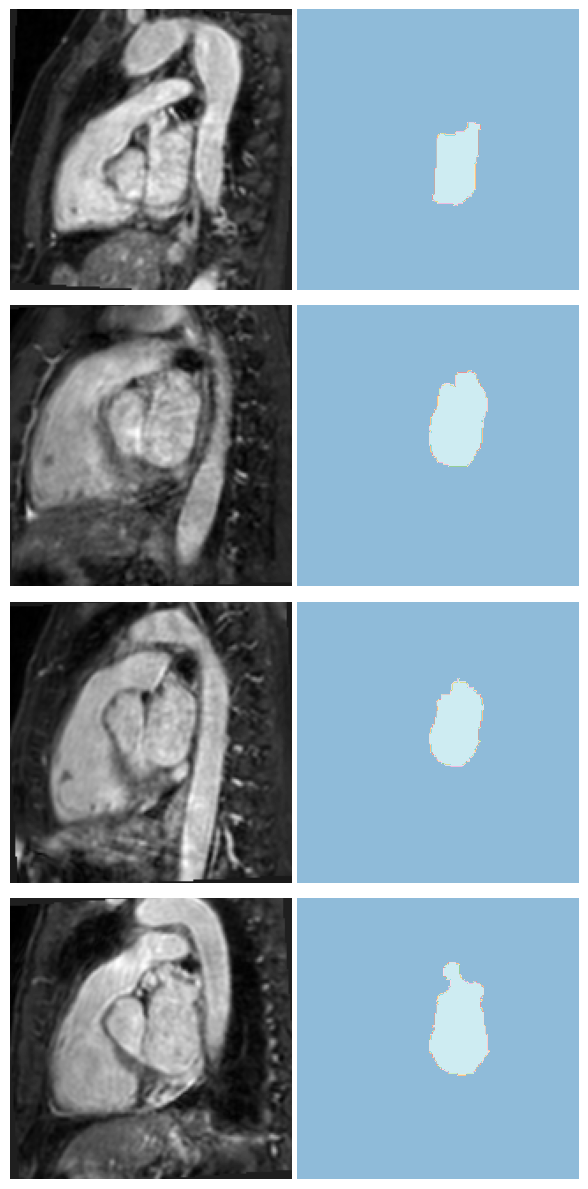

In [18]:
dls.show_batch(anatomical_plane=2)

### Create and train a 3D model

The current state-of-the-art CNN models for medical image segmentation tasks are based on encoder-decoder architectures like the U-Net.
In the following line, we import an enhanced version of 3D UNet from MONAI. In addition, we import the Dice coefficient (Dice) loss, a commonly used loss function in medical image segmentation tasks:
\begin{equation*}
\begin{aligned}
loss = 1- \frac{y \cap \hat{y}}{\left | y \right |+\left | \hat{y} \right |}
\end{aligned}
\end{equation*}

In [19]:
from monai.networks.nets import UNet
from monai.losses import DiceLoss

In [20]:
model = UNet(spatial_dims=3, in_channels=1, out_channels=1, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), num_res_units=2)
model = model.model

In [21]:
loss_func = CustomLoss(loss_func=DiceLoss(sigmoid=True))

We use a built-in ranger optimizer from fastai, that combines (RAdam + Lookahead) into a single optimizer.
<i>Ranger21 tested with fastai available:</i> https://github.com/lessw2020/Ranger21

In [22]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=binary_dice_score)

SuggestedLRs(valley=0.007585775572806597)

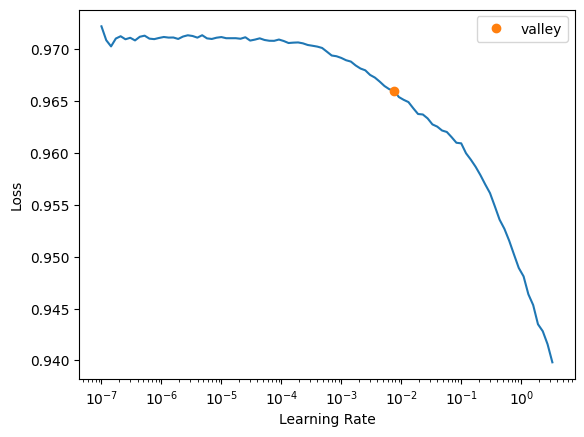

In [23]:
learn.lr_find()

In [24]:
lr = 1e-2

As shown in https://walkwithfastai.com/Segmentation, with the ranger optimizer, we want to use a different fit function, called `fit_flat_cos`

In [25]:
learn.fit_flat_cos(200 ,lr)

epoch,train_loss,valid_loss,binary_dice_score,time
0,0.970312,0.970365,0.024986,00:18
1,0.970226,0.967031,0.028426,00:17
2,0.968558,0.960297,0.030373,00:18
3,0.966067,0.958923,0.033146,00:20
4,0.964031,0.959129,0.037662,00:18
5,0.962245,0.955086,0.039104,00:17
6,0.960989,0.953478,0.043631,00:16
7,0.959851,0.953172,0.042526,00:18
8,0.958730,0.952422,0.045914,00:18
9,0.957683,0.951857,0.053510,00:18


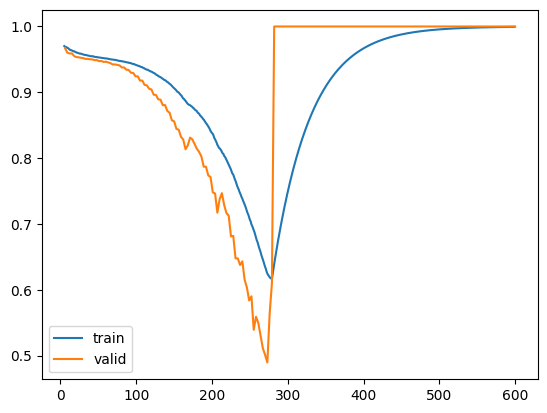

In [26]:
learn.recorder.plot_loss()

In [ ]:
learn.save('heart-model')

Path('models/heart-model.pth')

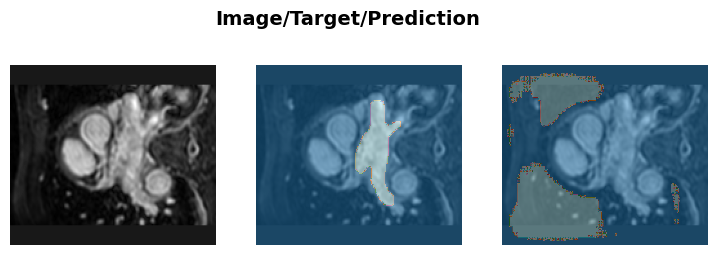

In [27]:
learn.show_results(anatomical_plane=1)

### Test data (with labels to evaulate the model)
Evaluate the performance of the selected model on unseen data.
It’s important to not touch this data until you have fine tuned your model to get an unbiased evaluation!

In [28]:
learn.load('heart-model');

FileNotFoundError: [Errno 2] No such file or directory: 'models/heart-model.pth'

In [29]:
test_dl = learn.dls.test_dl(test_df,with_labels=True)

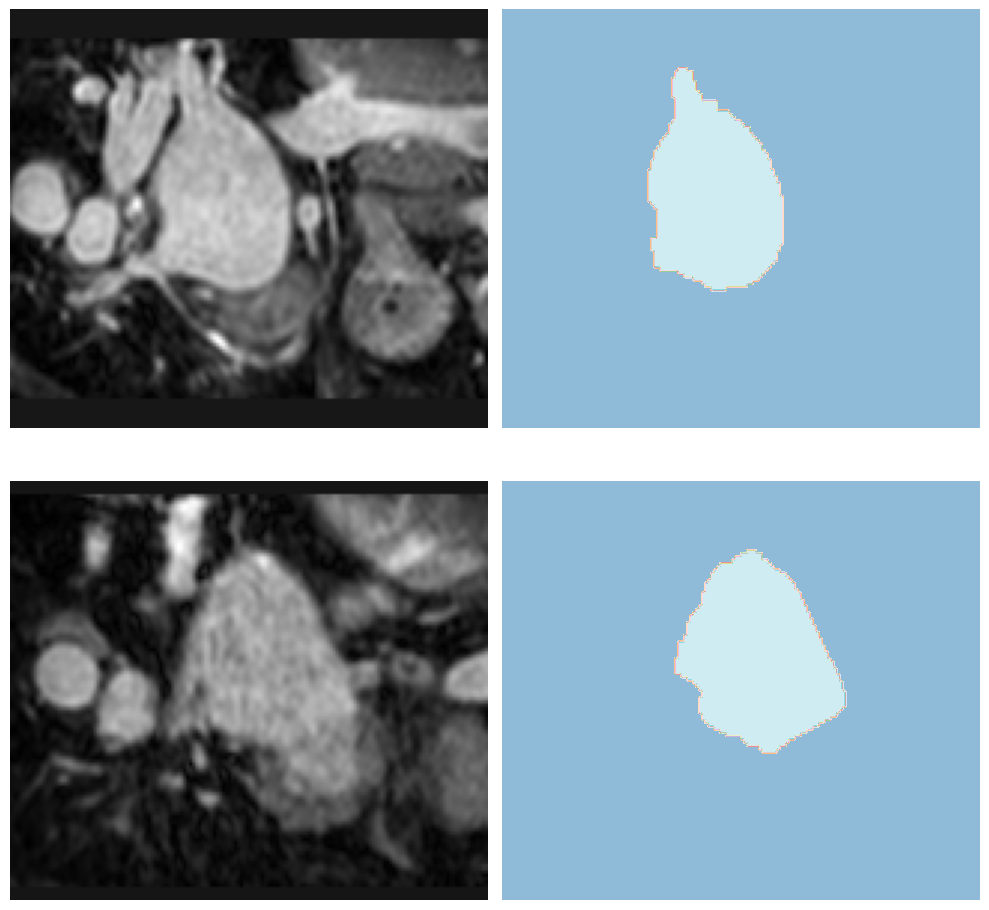

In [30]:
test_dl.show_batch(anatomical_plane=0, figsize=(10,10))

In [31]:
pred_acts, labels = learn.get_preds(dl=test_dl)
pred_acts.shape, labels.shape

(torch.Size([2, 1, 160, 160, 128]), torch.Size([2, 1, 160, 160, 128]))

In [32]:
binary_dice_score(pred_acts, labels)

tensor(0.)

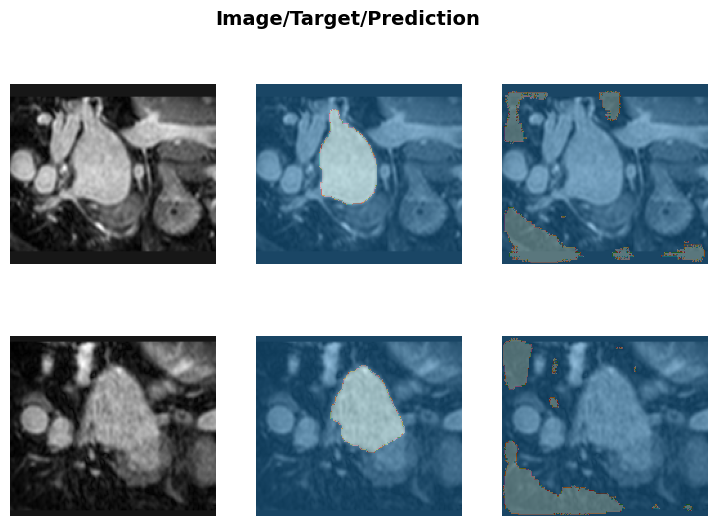

In [33]:
learn.show_results(anatomical_plane=0, dl=test_dl)

### Export learner

In [ ]:
store_variables(pkl_fn='vars.pkl', size=size, reorder=reorder,  resample=resample)

In [ ]:
learn.export('heart_model.pkl')